In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Check data directory
import os
os.listdir('/content/drive/MyDrive/Alzheimers1')

['test_set', 'train_set']

In [ ]:
import pandas as pd
import os
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import numpy as np
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
pip install datasets

In [ ]:
from datasets import load_dataset
data_dir = '/content/drive/MyDrive/Alzheimers1'

# load dataset
train_ds = load_dataset("imagefolder", data_dir=os.path.join(data_dir, "train_set"), split="train")
test_ds = load_dataset("imagefolder", data_dir=os.path.join(data_dir, "test_set"), split="train")

# label2idx and idx2label
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
# split train, val
splits = train_ds.train_test_split(test_size=0.1, shuffle=True, seed=42)
train_ds, val_ds = splits["train"], splits["test"]
print("Features", train_ds.features)
print("Train", train_ds)
print("Validation", val_ds)
print("Test", test_ds)
print("Num labels", len(label2id))
print("Label2Idx", label2id)

Resolving data files:   0%|          | 0/6400 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1600 [00:00<?, ?it/s]

Features {'image': Image(decode=True, id=None), 'label': ClassLabel(names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], id=None)}
Train Dataset({
    features: ['image', 'label'],
    num_rows: 5760
})
Validation Dataset({
    features: ['image', 'label'],
    num_rows: 640
})
Test Dataset({
    features: ['image', 'label'],
    num_rows: 1600
})
Num labels 4
Label2Idx {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


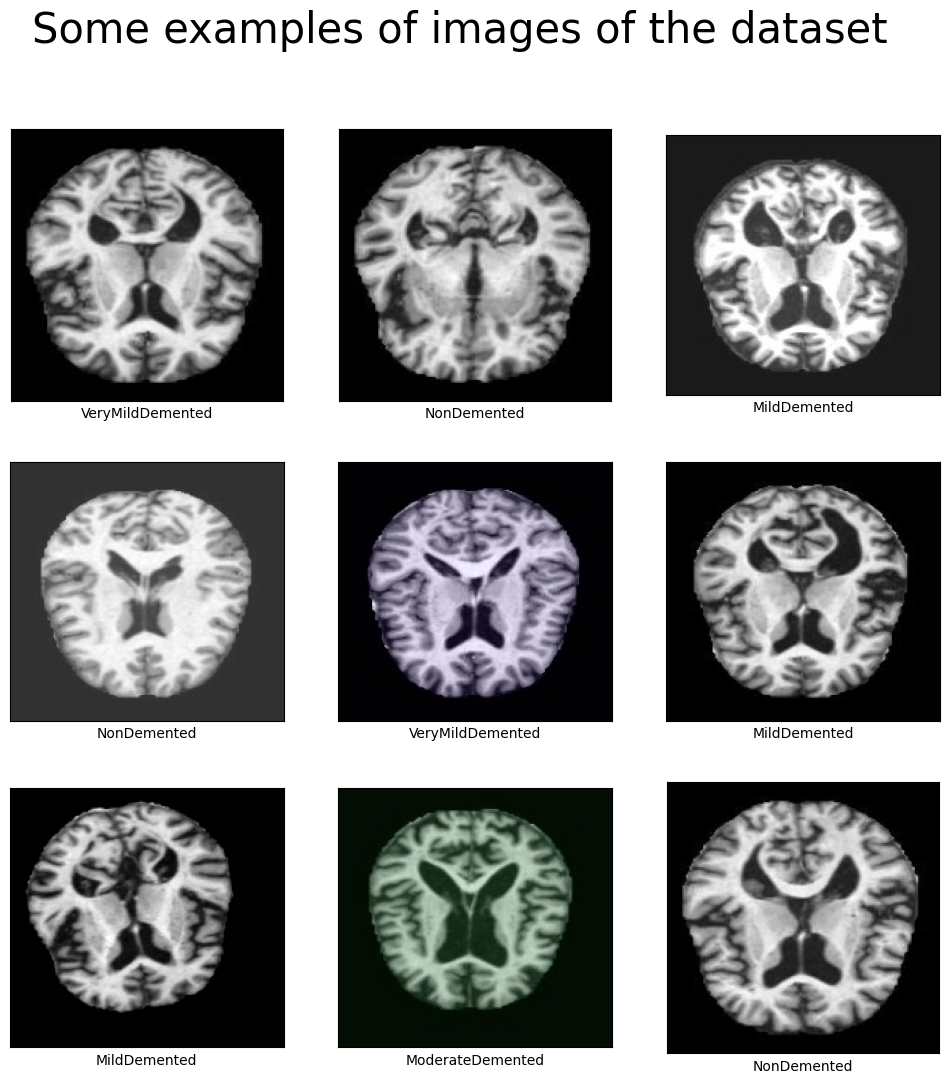

In [ ]:
import cv2
import matplotlib.pyplot as plt
from random import randint
list_idx = [randint(0, len(train_ds)) for i in range(9)]
def display_examples():
    fig = plt.figure(figsize=(12,12))
    fig.suptitle("Some examples of images of the dataset", fontsize=30)
    for i, idx in enumerate(list_idx):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_ds[idx]["image"])
        plt.xlabel(id2label[train_ds[idx]["label"]])
    plt.show()

display_examples()

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoFeatureExtractor
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
    RandomRotation,
    ColorJitter,
    RandomGrayscale,
    RandomVerticalFlip
)

feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

# Tambahkan pernyataan print di sini
print(feature_extractor.size)

# Dapatkan nilai height dan width
height = feature_extractor.size['height']
width = feature_extractor.size['width']

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

# Tambahkan augmentasi tambahan di sini
additional_transforms = Compose([
    RandomRotation(degrees=15),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    RandomGrayscale(p=0.1),
    RandomVerticalFlip(p=0.1)
])

_train_transforms = Compose(
        [
            Resize((height, width)),
            RandomResizedCrop((height, width)),
            RandomHorizontalFlip(),
            additional_transforms,  # Tambahkan augmentasi tambahan di sini
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize((height, width)),
            CenterCrop((height, width)),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

{'height': 224, 'width': 224}


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
feature_extractor.image_mean, feature_extractor.image_std

([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

In [ ]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [ ]:
from transformers import ViTForImageClassification, ViTConfig

config = ViTConfig.from_pretrained(
        "google/vit-base-patch16-224",
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        finetuning_task="image-classification"
    )

# Menambahkan dropout ke model
config.drop_path_rate = 0.2  # Atur tingkat dropout yang diinginkan

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    config=config,
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install accelerator

In [ ]:
!pip install transformers torch torchvision

In [ ]:
pip install transformers[torch]

In [ ]:
!pip install accelerate -U

In [ ]:
from transformers import TrainingArguments, Trainer
metric_name = "accuracy"
args = TrainingArguments(
    f"faceshape",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=30,
    weight_decay=0.1,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
from datasets import load_metric
import numpy as np

metric = load_metric(metric_name)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-19-edff0a708c3e>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric(metric_name)
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)

criterion = nn.CrossEntropyLoss()

val_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=4)

In [ ]:
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

Epoch [1/30], Train Loss: 0.9400, Validation Loss: 0.7691, Train Accuracy: 57.29%, Validation Accuracy: 63.44%
Epoch [2/30], Train Loss: 0.7421, Validation Loss: 0.6077, Train Accuracy: 66.70%, Validation Accuracy: 71.25%
Epoch [3/30], Train Loss: 0.6811, Validation Loss: 0.5947, Train Accuracy: 68.73%, Validation Accuracy: 70.62%
Epoch [4/30], Train Loss: 0.6263, Validation Loss: 0.5166, Train Accuracy: 71.94%, Validation Accuracy: 77.03%
Epoch [5/30], Train Loss: 0.5703, Validation Loss: 0.4484, Train Accuracy: 74.32%, Validation Accuracy: 80.16%
Epoch [6/30], Train Loss: 0.5141, Validation Loss: 0.4197, Train Accuracy: 77.60%, Validation Accuracy: 82.81%
Epoch [7/30], Train Loss: 0.4738, Validation Loss: 0.3597, Train Accuracy: 79.51%, Validation Accuracy: 84.06%
Epoch [8/30], Train Loss: 0.4213, Validation Loss: 0.4011, Train Accuracy: 82.27%, Validation Accuracy: 83.12%
Epoch [9/30], Train Loss: 0.3885, Validation Loss: 0.3086, Train Accuracy: 83.92%, Validation Accuracy: 87.34%
E

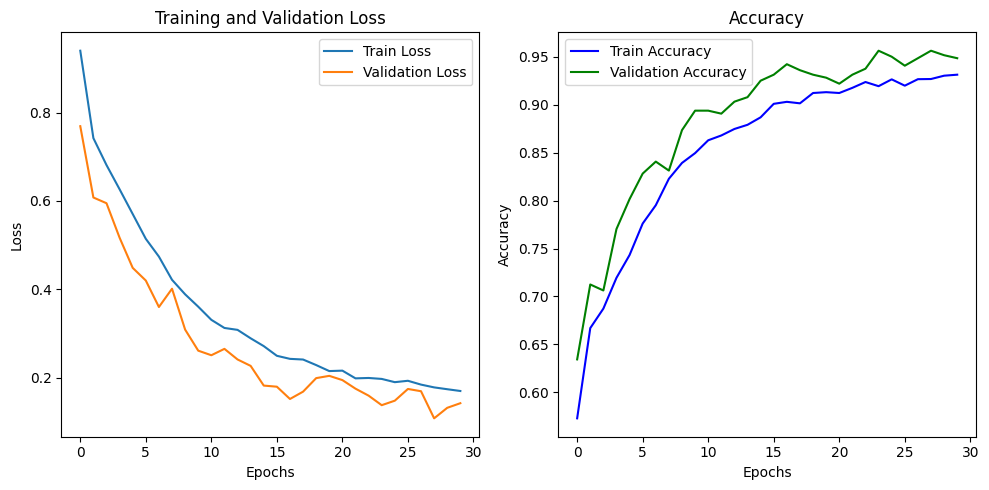

In [ ]:
import matplotlib.pyplot as plt

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(args.num_train_epochs):
    correct_predictions_train = 0
    total_predictions_train = 0
    correct_predictions_val = 0
    total_predictions_val = 0

    total_train_loss = 0
    total_val_loss = 0

    # Training
    model.train()
    for batch in train_dataloader:
        try:
            pixel_values, labels = batch["pixel_values"].to(device), batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(pixel_values)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total_predictions_train += labels.size(0)
            correct_predictions_train += (predicted == labels).sum().item()
        except Exception as e:
            print(f"Error: {e}")
            continue  # Melanjutkan iterasi ke iterasi berikutnya jika terjadi kesalahan

    # Validation
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            try:
                pixel_values, labels = batch["pixel_values"].to(device), batch["labels"].to(device)

                outputs = model(pixel_values)
                loss = criterion(outputs.logits, labels)

                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.logits, 1)
                total_predictions_val += labels.size(0)
                correct_predictions_val += (predicted == labels).sum().item()
            except Exception as e:
                print(f"Error: {e}")
                continue  # Melanjutkan iterasi ke iterasi berikutnya jika terjadi kesalahan

    average_train_loss = total_train_loss / len(train_dataloader)
    average_val_loss = total_val_loss / len(val_dataloader)

    train_losses.append(average_train_loss)
    val_losses.append(average_val_loss)

    # Hitung akurasi train
    try:
        accuracy_train = correct_predictions_train / total_predictions_train
    except ZeroDivisionError:
        accuracy_train = 0.0  # Atasi jika terjadi ZeroDivisionError
    train_accuracies.append(accuracy_train)

    # Hitung akurasi validasi
    try:
        accuracy_val = correct_predictions_val / total_predictions_val
    except ZeroDivisionError:
        accuracy_val = 0.0  # Atasi jika terjadi ZeroDivisionError
    val_accuracies.append(accuracy_val)

    print(f"Epoch [{epoch+1}/{args.num_train_epochs}], "
          f"Train Loss: {average_train_loss:.4f}, "
          f"Validation Loss: {average_val_loss:.4f}, "
          f"Train Accuracy: {accuracy_train * 100:.2f}%, "
          f"Validation Accuracy: {accuracy_val * 100:.2f}%")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
trainer.evaluate()

{'eval_loss': 0.1419665813446045,
 'eval_accuracy': 0.9484375,
 'eval_runtime': 9.9777,
 'eval_samples_per_second': 64.143,
 'eval_steps_per_second': 2.004}

In [ ]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
labels = train_ds.features['label'].names

{'test_loss': 0.11227986216545105, 'test_accuracy': 0.959375, 'test_runtime': 971.5425, 'test_samples_per_second': 1.647, 'test_steps_per_second': 0.051}


In [ ]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels))

                  precision    recall  f1-score   support

    MildDemented       0.97      0.97      0.97       400
ModerateDemented       1.00      1.00      1.00       400
     NonDemented       0.98      0.89      0.93       400
VeryMildDemented       0.90      0.97      0.93       400

        accuracy                           0.96      1600
       macro avg       0.96      0.96      0.96      1600
    weighted avg       0.96      0.96      0.96      1600



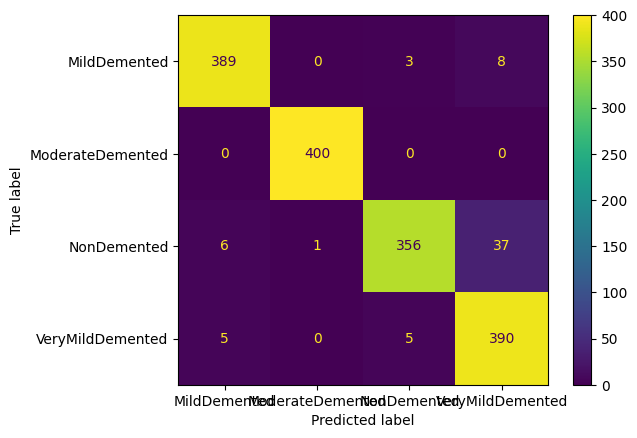

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

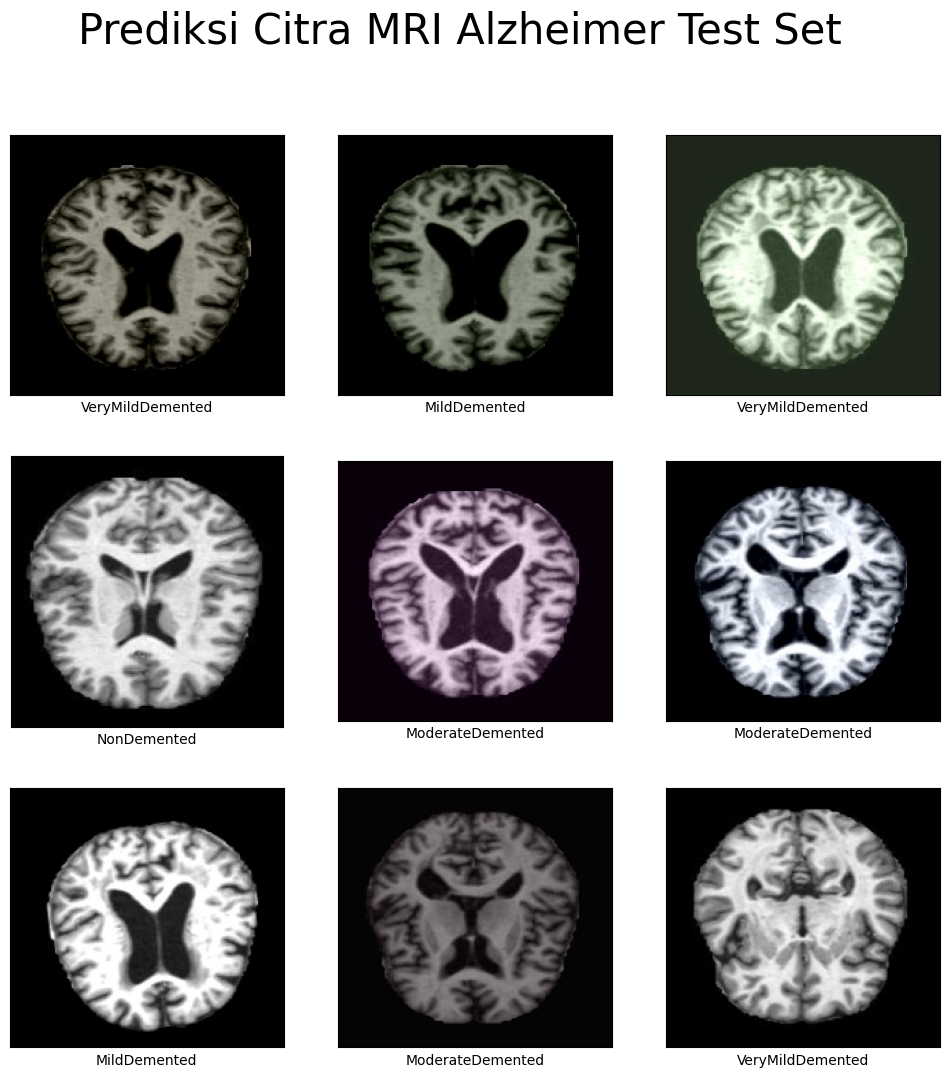

In [ ]:
import cv2
import matplotlib.pyplot as plt
from random import randint

list_idx = [randint(0, len(test_ds)) for i in range(9)]

def display_examples():
    fig = plt.figure(figsize=(12,12))
    fig.suptitle("Prediksi Citra MRI Alzheimer Test Set", fontsize=30)
    for i,idx in enumerate(list_idx):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_ds[idx]["image"])
        plt.xlabel(id2label[y_pred[idx]])
    plt.show()

display_examples()